# Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Environment setup

All required packages can be found in the accompanying requirements.txt file.

In [2]:
!pip install -r requirements.txt

### Data download

To download the dataset required for this project, we use `opendatasets` which is a Python library that simplifies the process of downloading datasets from online sources like Kaggle.


Before running the next cell, you will need to visit [Kaggle](https://www.kaggle.com/) and obtain your API token. Over there, navigate to your account's settings where you will see an API section. Create a new API token and open the kaggle.json file produced. In here, you will find your username and key which will be prompted for when you run the next cell.

In [3]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents")

Skipping, found downloaded files in "./us-accidents" (use force=True to force download)


# Exploration

The downloaded dataset has a size of 3.06 GB as of July 2024. This data size is less than the memory size of most machines. Although this data size is manageable for most machines, the memory requirement can exceed the dataset size several times during compute-intensive steps such as preprocessing, training, and inference. Additionally, the US Accidents dataset uses multiple APIs to regularly keep itself up-to-date, implying the dataset size and the consequent memory requirement will continue to grow.

With this in mind, we have decided to to use PySpark for data exploration, data preprocessing, and model training, while occasionally sampling a subset of the data to create visualizations using Pandas, Seaborn, and/or Matplotlib.

### Creating a PySpark session and loading the dataset

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config('spark.executor.instances', 7) \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/31 19:53:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
path = "us-accidents/US_Accidents_March23.csv"
df = spark.read.csv(path, header=True, inferSchema=True)

24/07/31 19:53:50 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


### Basic EDA

Before we use PySpark to perform basic EDA operations to understand the dataset, here are the column descriptions provided by the dataset owners in the accompanying [arXiv paper](https://arxiv.org/pdf/2402.15809).

<table>
  <tr>
    <th>ID</th>
    <td>This is a unique identifier of the accident record.</td>
  </tr>
  <tr>
    <th>Source</th>
    <td>Source of raw accident data.</td>
  </tr>
  <tr>
    <th>Severity</th>
    <td>Shows the severity of the accident, a number between 1 and 4, where 1 indicates the least impact on traffic (i.e., short delay as a result of the accident) and 4 indicates a significant impact on traffic (i.e., long delay).</td>
  </tr>
  <tr>
    <th>Start_Time</th>
    <td>Shows start time of the accident in local time zone.</td>
  </tr>
  <tr>
    <th>End_Time</th>
    <td>Shows end time of the accident in local time zone. End time here refers to when the impact of accident on traffic flow was dismissed.</td>
  </tr>
  <tr>
    <th>Start_Lat</th>
    <td>Shows latitude in GPS coordinate of the start point.</td>
  </tr>
  <tr>
    <th>Start_Lng</th>
    <td>Shows longitude in GPS coordinate of the start point.</td>
  </tr>
  <tr>
    <th>End_Lat</th>
    <td>Shows latitude in GPS coordinate of the end point.</td>
  </tr>
  <tr>
    <th>End_Lng</th>
    <td>Shows longitude in GPS coordinate of the end point.</td>
  </tr>
  <tr>
    <th>Distance(mi)</th>
    <td>The length of the road extent affected by the accident in miles.</td>
  </tr>
  <tr>
    <th>Description</th>
    <td>Shows a human provided description of the accident.</td>
  </tr>
  <tr>
    <th>Street</th>
    <td>Shows the street name in address field.</td>
  </tr>
  <tr>
    <th>City</th>
    <td>Shows the city in address field.</td>
  </tr>
  <tr>
    <th>County</th>
    <td>Shows the county in address field.</td>
  </tr>
  <tr>
    <th>State</th>
    <td>Shows the state in address field.</td>
  </tr>
  <tr>
    <th>Zipcode</th>
    <td>Shows the zipcode in address field.</td>
  </tr>
  <tr>
    <th>Country</th>
    <td>Shows the country in address field.</td>
  </tr>
  <tr>
    <th>Timezone</th>
    <td>Shows timezone based on the location of the accident (eastern, central, etc.).</td>
  </tr>
  <tr>
    <th>Airport_Code</th>
    <td>Denotes an airport-based weather station which is the closest one to location of the accident.</td>
  </tr>
  <tr>
    <th>Weather_Timestamp</th>
    <td>Shows the time-stamp of weather observation record (in local time).</td>
  </tr>
  <tr>
    <th>Temperature(F)</th>
    <td>Shows the temperature (in Fahrenheit).</td>
  </tr>
  <tr>
    <th>Wind_Chill(F)</th>
    <td>Shows the wind chill (in Fahrenheit).</td>
  </tr>
  <tr>
    <th>Humidity(%)</th>
    <td>Shows the humidity (in percentage).</td>
  </tr>
  <tr>
    <th>Pressure(in)</th>
    <td>Shows the air pressure (in inches).</td>
  </tr>
  <tr>
    <th>Visibility(mi)</th>
    <td>Shows visibility (in miles).</td>
  </tr>
  <tr>
    <th>Wind_Direction</th>
    <td>Shows wind direction.</td>
  </tr>
  <tr>
    <th>Wind_Speed(mph)</th>
    <td>Shows wind speed (in miles per hour).</td>
  </tr>
  <tr>
    <th>Precipitation(in)</th>
    <td>Shows precipitation amount in inches, if there is any.</td>
  </tr>
  <tr>
    <th>Weather_Condition</th>
    <td>Shows the weather condition (rain, snow, thunderstorm, fog, etc.).</td>
  </tr>
  <tr>
    <th>Amenity</th>
    <td>A POI annotation which indicates presence of amenity in a nearby location.</td>
  </tr>
  <tr>
    <th>Bump</th>
    <td>A POI annotation which indicates presence of speed bump or hump in a nearby location.</td>
  </tr>
  <tr>
    <th>Crossing</th>
    <td>A POI annotation which indicates presence of crossing in a nearby location.</td>
  </tr>
  <tr>
    <th>Give_Way</th>
    <td>A POI annotation which indicates presence of give_way in a nearby location.</td>
  </tr>
  <tr>
    <th>Junction</th>
    <td>A POI annotation which indicates presence of junction in a nearby location.</td>
  </tr>
  <tr>
    <th>No_Exit</th>
    <td>A POI annotation which indicates presence of no_exit in a nearby location.</td>
  </tr>
  <tr>
    <th>Railway</th>
    <td>A POI annotation which indicates presence of railway in a nearby location.</td>
  </tr>
  <tr>
    <th>Roundabout</th>
    <td>A POI annotation which indicates presence of roundabout in a nearby location.</td>
  </tr>
  <tr>
    <th>Station</th>
    <td>A POI annotation which indicates presence of station in a nearby location.</td>
  </tr>
  <tr>
    <th>Stop</th>
    <td>A POI annotation which indicates presence of stop in a nearby location.</td>
  </tr>
  <tr>
    <th>Traffic_Calming</th>
    <td>A POI annotation which indicates presence of traffic_calming in a nearby location.</td>
  </tr>
  <tr>
    <th>Traffic_Signal</th>
    <td>A POI annotation which indicates presence of traffic_signal in a nearby location.</td>
  </tr>
  <tr>
    <th>Turning_Loop</th>
    <td>A POI annotation which indicates presence of turning_loop in a nearby location.</td>
  </tr>
  <tr>
    <th>Sunrise_Sunset</th>
    <td>Shows the period of day (i.e. day or night) based on sunrise/sunset.</td>
  </tr>
  <tr>
    <th>Civil_Twilight</th>
    <td>Shows the period of day (i.e. day or night) based on civil twilight.</td>
  </tr>
  <tr>
    <th>Nautical_Twilight</th>
    <td>Shows the period of day (i.e. day or night) based on nautical twilight.</td>
  </tr>
  <tr>
    <th>Astronomical_Twilight</th>
    <td>Shows the period of day (i.e. day or night) based on astronomical twilight.</td>
  </tr>
</table>

In [6]:
df.count()

7728394

In [7]:
len(df.columns)

46

In [8]:
df.show(n=3, vertical=True)

-RECORD 0-------------------------------------
 ID                    | A-1                  
 Source                | Source2              
 Severity              | 3                    
 Start_Time            | 2016-02-08 05:46:00  
 End_Time              | 2016-02-08 11:00:00  
 Start_Lat             | 39.865147            
 Start_Lng             | -84.058723           
 End_Lat               | NULL                 
 End_Lng               | NULL                 
 Distance(mi)          | 0.01                 
 Description           | Right lane blocke... 
 Street                | I-70 E               
 City                  | Dayton               
 County                | Montgomery           
 State                 | OH                   
 Zipcode               | 45424                
 Country               | US                   
 Timezone              | US/Eastern           
 Airport_Code          | KFFO                 
 Weather_Timestamp     | 2016-02-08 05:58:00  
 Temperature(

24/07/31 19:54:01 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [9]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- V

In [10]:
df.describe().show(vertical=True)

-RECORD 0-------------------------------------
 summary               | count                
 ID                    | 7728394              
 Source                | 7728394              
 Severity              | 7728394              
 Start_Lat             | 7728394              
 Start_Lng             | 7728394              
 End_Lat               | 4325632              
 End_Lng               | 4325632              
 Distance(mi)          | 7728394              
 Description           | 7728389              
 Street                | 7717525              
 City                  | 7728141              
 County                | 7728394              
 State                 | 7728394              
 Zipcode               | 7726479              
 Country               | 7728394              
 Timezone              | 7720586              
 Airport_Code          | 7705759              
 Temperature(F)        | 7564541              
 Wind_Chill(F)         | 5729375              
 Humidity(%) 

With 7728394 columns and 46 rows, this dataset is big. Since our primary goal, is to build a reliable model to predict accident severity, not all of the above column features would be relevant. Therefore, we use intuition to drop the following columns during the data preprocessing phase:

- `ID`, `Source`, `Timezone`, `Airport_Code`, `Weather_Timestamp`: these variables do not carry any information relevant to accident severity.
- `Street`, `County`, `State`, `Zipcode`, `Country`: instead of these variables, we focus instead on the variable `City` to provide the same information (`Country` is completely redundant).
- `Civil_Twilight`, `Nautical_Twilight`, `Astronomical_Twilight`: instead of these variables, we focus instead on the variable `Sunrise_Sunset` to provide the same/more relevant information.
- `Turning_Loop`: this variable is always false and provides no new information.
- `Description`: for simplicity, we drop this variable to not delve into the complexity of a natural language processing (NLP) task.

The most promising variables seem to be of the following two categories:
- Point of Interest (POI) annotations like `Amenity`, `Bump`, `Crossing`, `Give_Way`, `Junction`, `No_Exit`, `Railway`, `Roundabout`, `Station`, `Stop`, `Traffic_Calming`, and `Traffic_Calming`.
- Weather and time variables like `Weather_Timestamp`, `Temperature`, `Wind_Chill`, `Humidity`, `Pressure`, `Visibility`, `Wind_Direction`, `Wind_Speed`, `Precipitation`, and `Weather_Condition`.

In [11]:
from pyspark.sql.functions import col, sum as _sum

missing_counts = df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_counts.show(vertical=True)

-RECORD 0------------------------
 ID                    | 0       
 Source                | 0       
 Severity              | 0       
 Start_Time            | 0       
 End_Time              | 0       
 Start_Lat             | 0       
 Start_Lng             | 0       
 End_Lat               | 3402762 
 End_Lng               | 3402762 
 Distance(mi)          | 0       
 Description           | 5       
 Street                | 10869   
 City                  | 253     
 County                | 0       
 State                 | 0       
 Zipcode               | 1915    
 Country               | 0       
 Timezone              | 7808    
 Airport_Code          | 22635   
 Weather_Timestamp     | 120228  
 Temperature(F)        | 163853  
 Wind_Chill(F)         | 1999019 
 Humidity(%)           | 174144  
 Pressure(in)          | 140679  
 Visibility(mi)        | 177098  
 Wind_Direction        | 175206  
 Wind_Speed(mph)       | 571233  
 Precipitation(in)     | 2203586 
 Weather_Condi

The above code cell shows the tally of missing values for each column in the dataset. There are a few variables that have more than a million missing columns (upto 3.4 million for `End_Lat` and `End_Lng`). This would mean that if we use these variables to predict severity and we drop the rows with missing values, we would end up losing a lot of valuable data. We will keep this in mind, when moving to feature selectoin and data preprocessing.

### Plots

In order to further explore some of these variable, we want to generate plots and visualizations. We will use a random sample of the PySpark dataset to generate these figures. We use a fixed seed for replication purposes.

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sampled_df = df.sample(fraction=0.01, seed=1234)
pandas_df = sampled_df.toPandas()

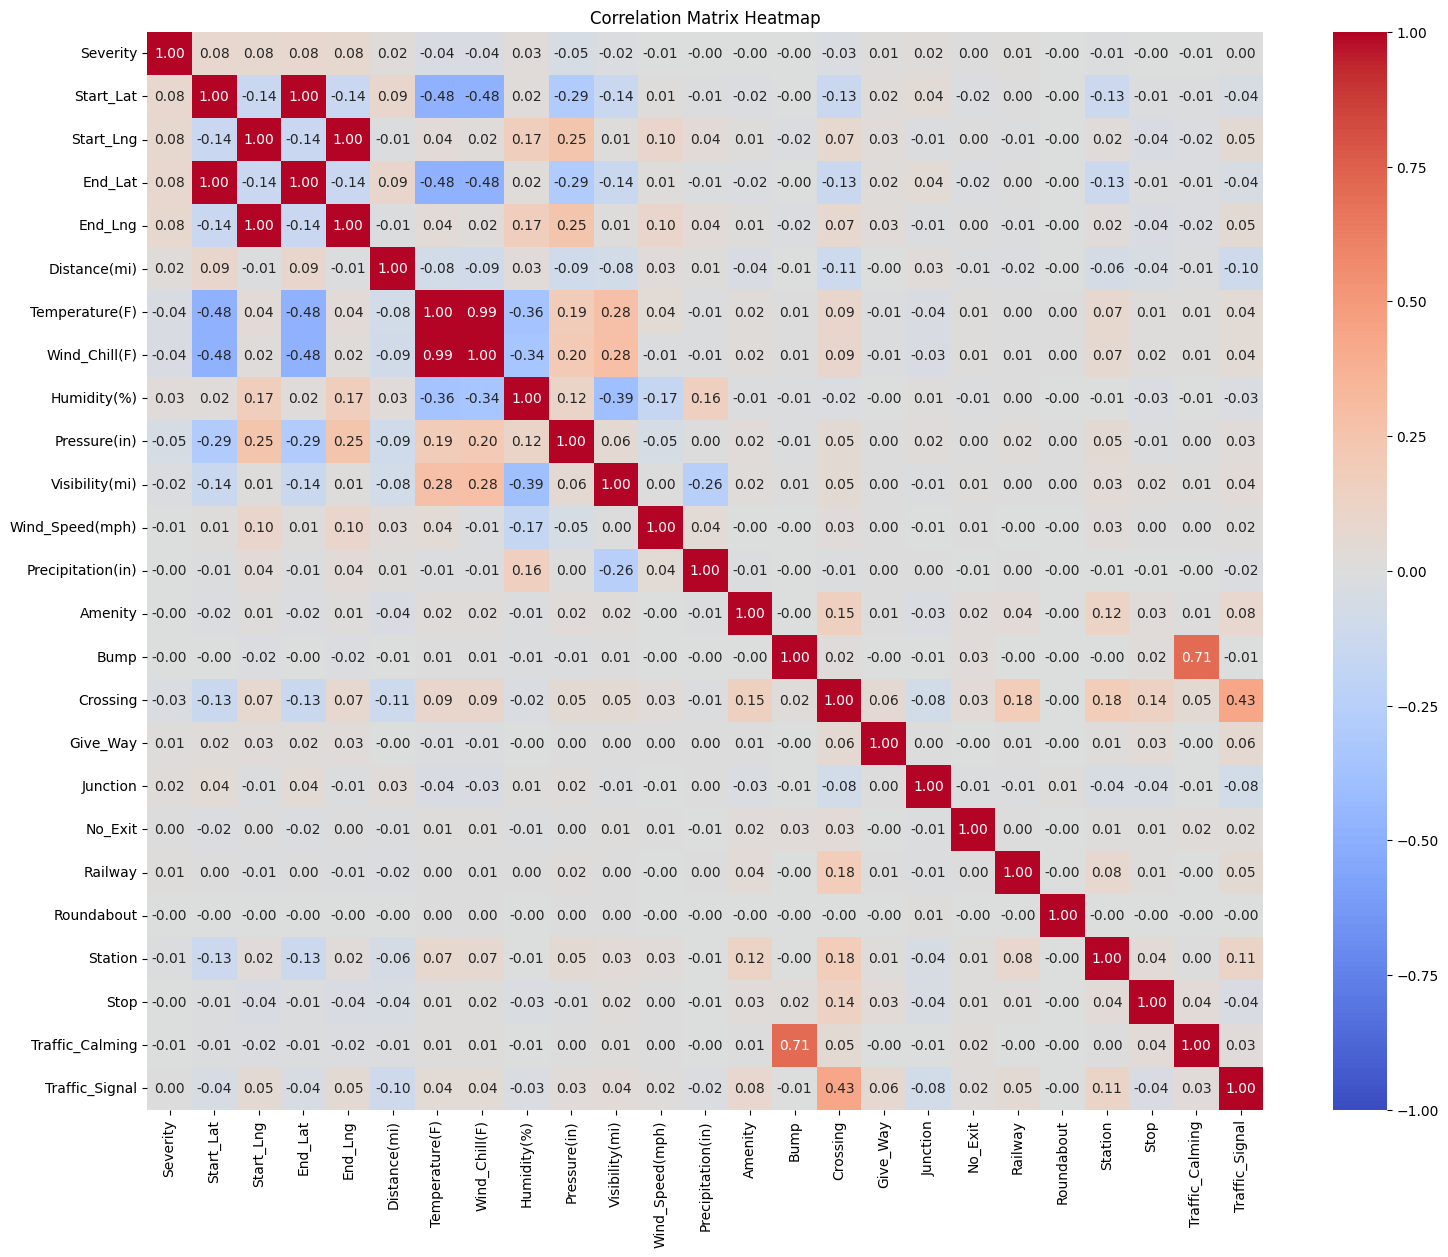

In [13]:
selected_columns = [
    'Severity', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
    'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
    'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Amenity', 'Bump',
    'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout',
    'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal'
]
heatmap_df = pandas_df[selected_columns]

boolean_columns = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']
heatmap_df[boolean_columns] = heatmap_df[boolean_columns].astype(int)
heatmap_df = heatmap_df.dropna()

correlation_matrix = heatmap_df.corr()
plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

This heatmap is very insightful. These are the key takeaways:
- `Temperature` and `Wind_Chill` have a very high correlation. As a result, in the data preprocessing stage we will only use one of these two variables to capture the information.
- `Start_Lat` is very strongly correlated with `End_Lat`. Since we earlier noticed that `End_Lat` has a lot of missing values, we will proceed only with the `Start_Lat` variable.
- Similarly, `Start_Lng` is very strongly correlated with `End_Lng`. Since we earlier noticed that `End_Lng` has a lot of missing values, we will proceed only with the `Start_Lng` variable.
- `Traffic_Calming` is associated with `Bump` and `Traffic Signal` is associated with `Crossing`.
- In general, the POI annotations have a lesser correlation with severity than the weather conditions. We will want to keep this in mind when choosing features for model training.

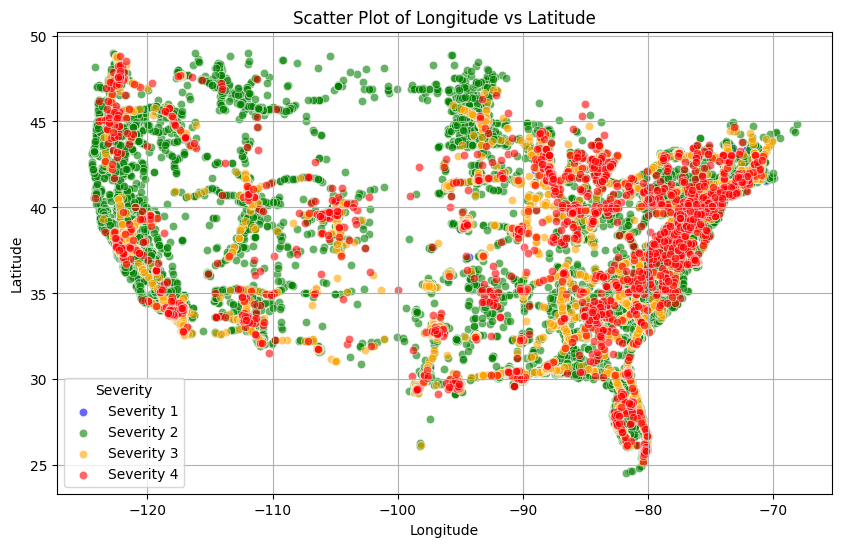

In [14]:
severity_colors = {1: 'blue', 2: 'green', 3: 'orange', 4: 'red'}

plt.figure(figsize=(10, 6))
for severity in severity_colors:
    subset = pandas_df[pandas_df['Severity'] == severity]
    plt.scatter(subset['Start_Lng'], subset['Start_Lat'],
                c=severity_colors[severity], label=f'Severity {severity}',
                alpha=0.6, edgecolors='w', linewidth=0.5)

plt.title('Scatter Plot of Longitude vs Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

plt.legend(title='Severity')
plt.show()

As expected, this scatterplot forms an outline of the US. Place inland are less populated and seem to have fewer accidents. This gives us a very strong visual representation of the association of the latitude and longitude with severity of accident.

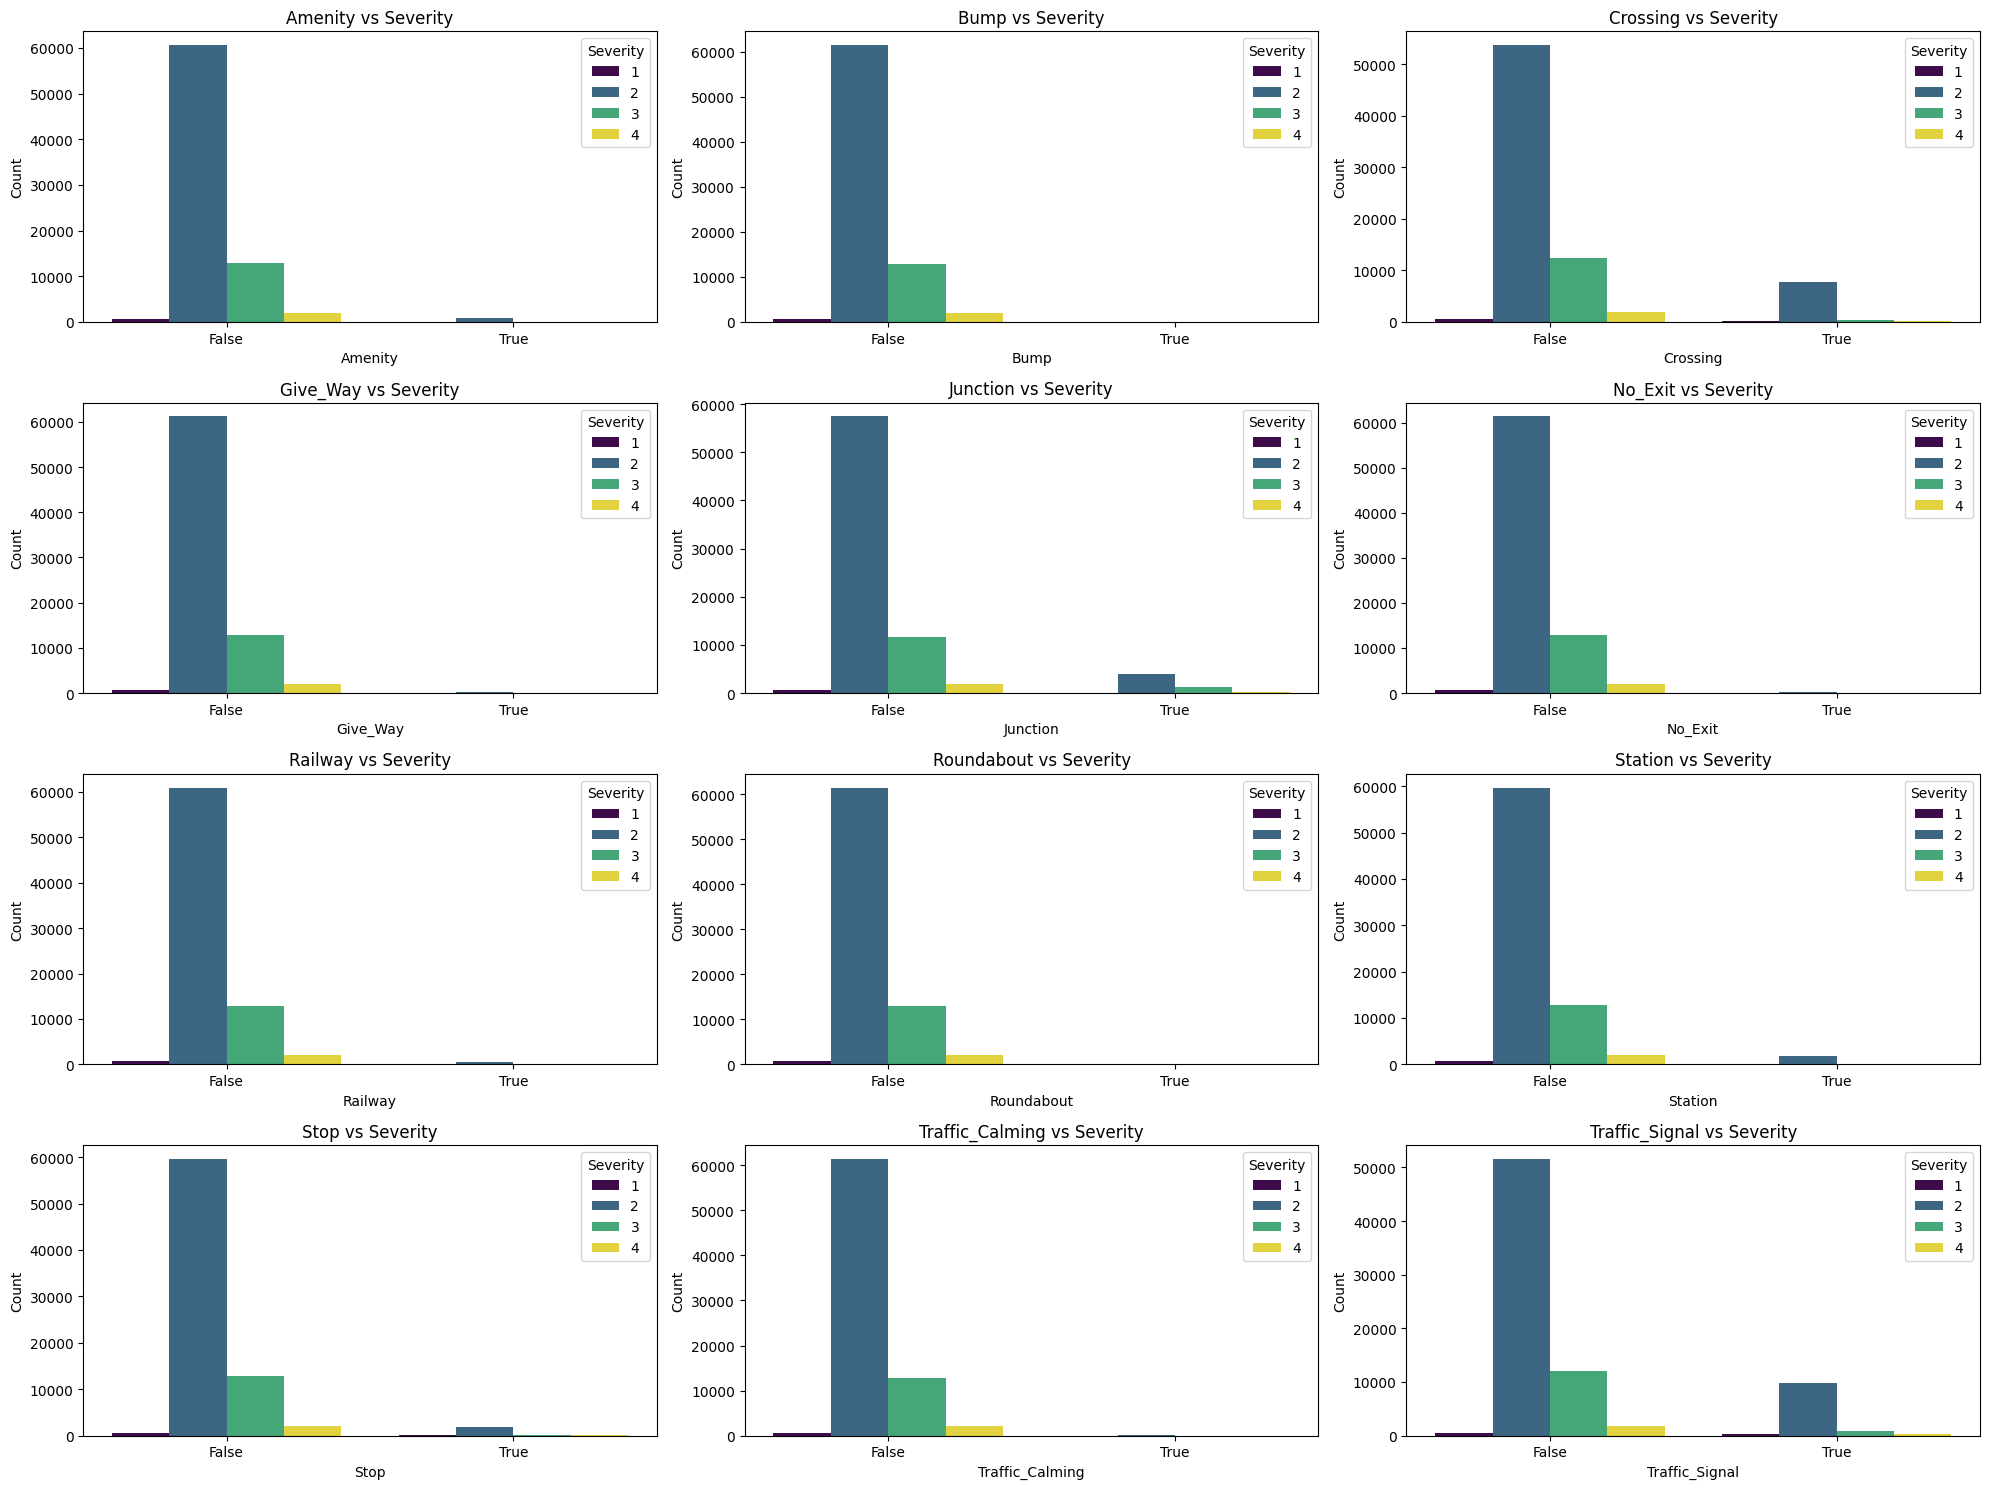

In [15]:
poi_columns = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
    'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal'
]

plt.figure(figsize=(20, 15))
for i, column in enumerate(poi_columns, 1):
    plt.subplot(4, 3, i)
    sns.countplot(x=column, hue='Severity', data=pandas_df, palette='viridis')
    plt.title(f'{column} vs Severity')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.legend(title='Severity')

plt.tight_layout()
plt.show()

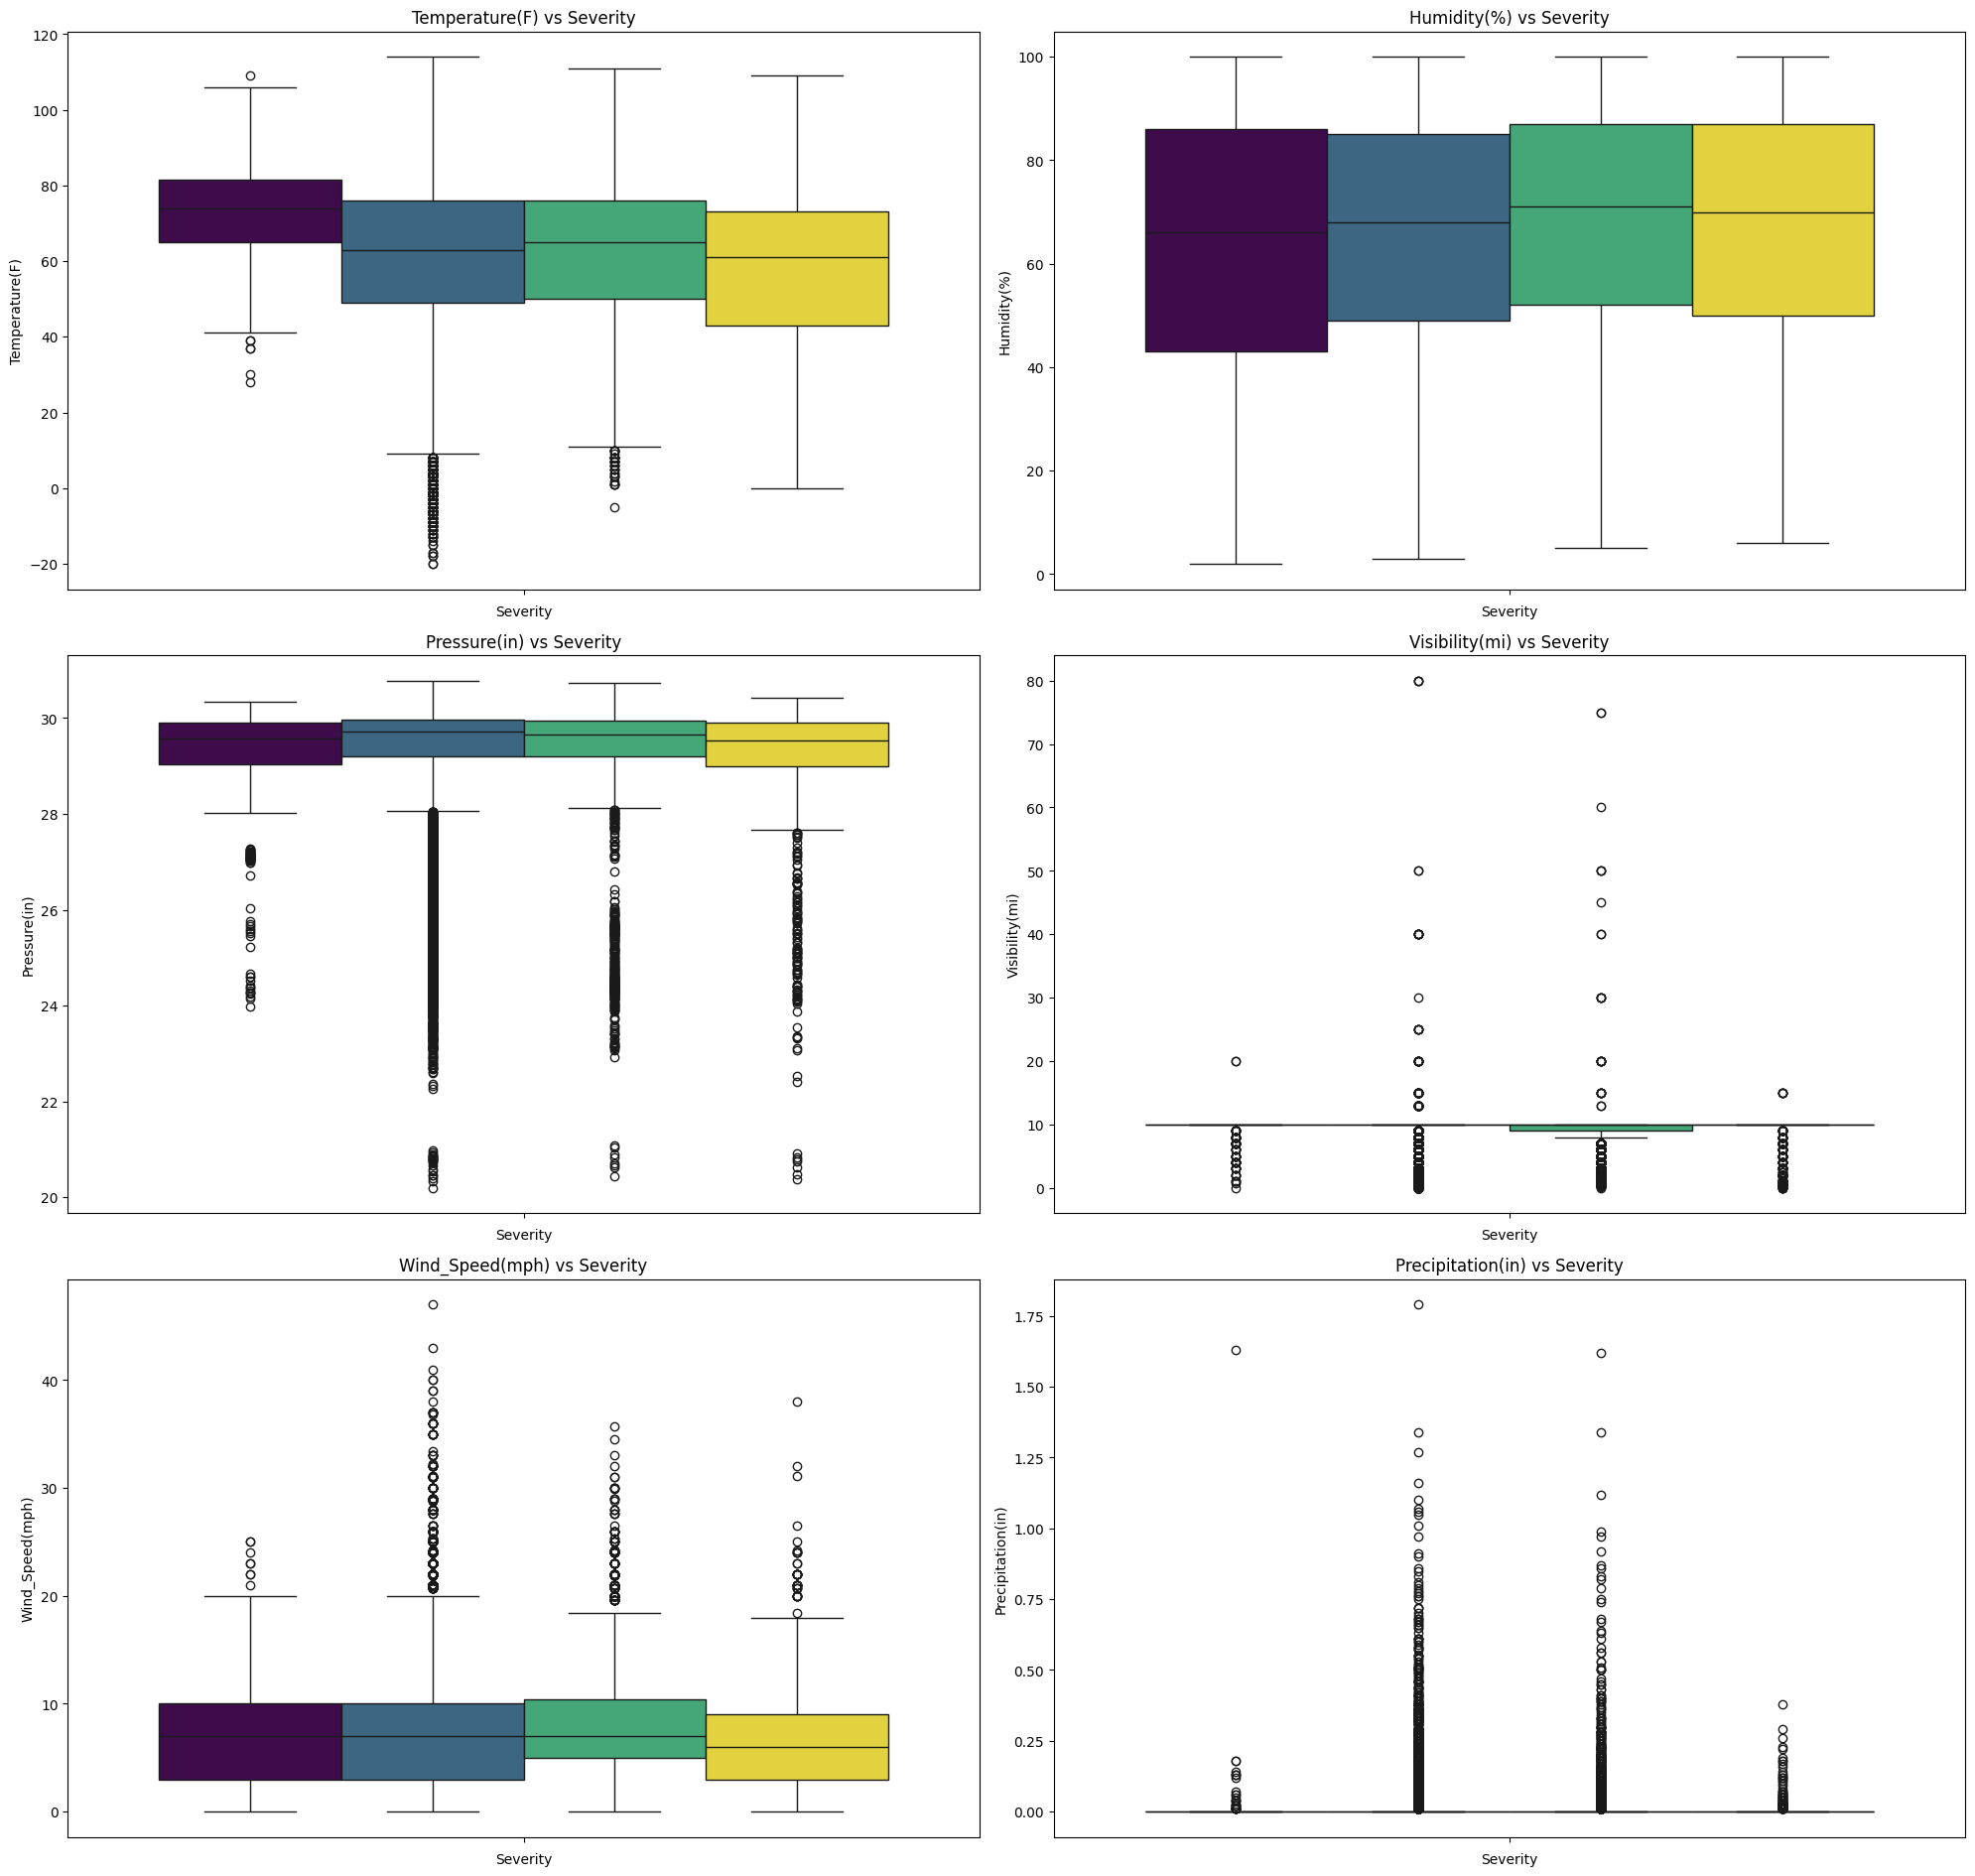

In [16]:
weather_columns = [
    'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
    'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)'
]

weather_df = pandas_df[['Severity'] + weather_columns].dropna()

plt.figure(figsize=(20, 25))
for i, column in enumerate(weather_columns, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(hue='Severity', y=column, data=weather_df, palette='viridis', legend=False)
    plt.title(f'{column} vs Severity')
    plt.xlabel('Severity')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

# Preprocessing

### Feature selection

We remove columns that are either redundant, not relevant for predicting severity, or have high correlation with other features we're keeping.

- **ID**: Unique identifier for each accident, not relevant for predicting severity.
- **Source**: Source of the data, not relevant for predicting severity.
- **End_Lat**: End latitude of the accident, highly correlated with Start_Lat and has many missing values.
- **End_Lng**: End longitude of the accident, highly correlated with Start_Lng and has many missing values.
- **Timezone**: Timezone of the accident, not directly relevant for severity prediction.
- **Airport_Code**: Nearby airport code, not relevant for predicting severity.
- **Weather_Timestamp**: Timestamp of the weather data, parsed into multiple useful features.
- **Street**: Street name, not relevant for predicting severity.
- **County**: County name, not relevant for predicting severity.
- **State**: State name, not relevant for predicting severity.
- **Zipcode**: Zipcode, not relevant for predicting severity.
- **Country**: Country name, redundant as all data is from the US.
- **Turning_Loop**: Always false, provides no new information.
- **Civil_Twilight**: Twilight phase, redundant when using Sunrise_Sunset.
- **Nautical_Twilight**: Twilight phase, redundant when using Sunrise_Sunset.
- **Astronomical_Twilight**: Twilight phase, redundant when using Sunrise_Sunset.
- **Description**: Text description of the accident, excluded to avoid complexity of NLP tasks.
- **Wind_Chill**: Highly correlated with Temperature, so we retain only Temperature.

In [18]:
columns_to_drop = ['ID', 'Source', 'End_Lat', 'End_Lng', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Description', 'Wind_Chill(F)']
df = df.drop(columns=columns_to_drop)
df.columns

Index(['Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Sunrise_Sunset'],
      dtype='object')

### Feature engineering

We extract useful time-related features from the 'Start_Time' column:

- Year
- Month
- Day
- Hour
- Minute
- Day of Week

This allows us to capture temporal patterns that might influence accident severity, such as rush hour traffic or seasonal variations.

In [19]:
# Parse 'Start_Time' into separate columns
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['Year'] = df['Start_Time'].dt.year
df['Month'] = df['Start_Time'].dt.month
df['Day'] = df['Start_Time'].dt.day
df['Hour'] = df['Start_Time'].dt.hour
df['Minute'] = df['Start_Time'].dt.minute
df['DayOfWeek'] = df['Start_Time'].dt.dayofweek

# Drop original 'Start_Time' and 'End_Time' columns
df = df.drop(['Start_Time', 'End_Time'], axis=1)

### One-hot encoding

#### Simplifying 'Wind_Direction'

We simplify the 'Wind_Direction' variable by grouping similar directions together:

- 'Calm' and 'CALM' are grouped as 'CALM'.
- 'West', 'WSW', and 'WNW' are grouped as 'W'.
- 'South', 'SSW', and 'SSE' are grouped as 'S'.
- 'North', 'NNW', and 'NNE' are grouped as 'N'.
- 'East', 'ESE', and 'ENE' are grouped as 'E'.
- 'Variable' is grouped as 'VAR'.

We then one-hot encode the simplified 'Wind_Direction' variable.

#### Simplifying and Encoding 'Weather_Condition'

We create binary features for common weather conditions:

- 'Clear'
- 'Cloud' (including 'Cloudy' and 'Overcast')
- 'Rain' (including 'Rain' and 'storm')
- 'Heavy_Rain' (including 'Heavy Rain', 'Rain Shower', 'Heavy T-Storm', 'Heavy Thunderstorms')
- 'Snow' (including 'Snow', 'Sleet', 'Ice')
- 'Heavy_Snow' (including 'Heavy Snow', 'Heavy Sleet', 'Heavy Ice Pellets', 'Snow Showers', 'Squalls')
- 'Fog'

We then drop the original 'Weather_Condition' column.

#### Encoding 'Sunrise_Sunset'

We convert 'Sunrise_Sunset' into a binary variable:

- 'Day' is encoded as 0.
- 'Night' is encoded as 1.

We handle any remaining missing values by filling them with the mode (most frequent value).

In [20]:
# Encode 'Sunrise_Sunset'
df['Sunrise_Sunset'] = df['Sunrise_Sunset'].map({'Night': 0, 'Day': 1})

# Encode 'Weather_Condition'
weather_conditions = {
    'Clear': 'Clear',
    'Partly Cloudy': 'Cloudy', 'Mostly Cloudy': 'Cloudy', 'Overcast': 'Cloudy', 'Scattered Clouds': 'Cloudy', 'Cloudy': 'Cloudy',
    'Rain': 'Rainy', 'Light Rain': 'Rainy', 'Heavy Rain': 'Rainy', 'Showers': 'Rainy', 'Thunderstorm': 'Rainy', 'Drizzle': 'Rainy',
    'Snow': 'Snowy', 'Light Snow': 'Snowy', 'Heavy Snow': 'Snowy', 'Sleet': 'Snowy', 'Hail': 'Snowy',
    'Fog': 'Foggy', 'Mist': 'Foggy', 'Haze': 'Foggy',
    'Other': 'Other'
}
df['Weather_Condition'] = df['Weather_Condition'].map(weather_conditions).fillna('Other')

# Encode 'Wind_Direction'
wind_directions = {
    'N': 'North', 'NNE': 'North', 'NE': 'North', 'ENE': 'North',
    'E': 'East', 'ESE': 'East', 'SE': 'East', 'SSE': 'East',
    'S': 'South', 'SSW': 'South', 'SW': 'South', 'WSW': 'South',
    'W': 'West', 'WNW': 'West', 'NW': 'West', 'NNW': 'West',
    'Calm': 'Calm', 'Variable': 'Variable'
}
df['Wind_Direction'] = df['Wind_Direction'].map(wind_directions).fillna('Variable')

# One-hot encode 'Weather_Condition' and 'Wind_Direction'
df = pd.get_dummies(df, columns=['Weather_Condition', 'Wind_Direction'], drop_first=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77099 entries, 0 to 77098
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Severity                  77099 non-null  int32  
 1   Start_Lat                 77099 non-null  float64
 2   Start_Lng                 77099 non-null  float64
 3   Distance(mi)              77099 non-null  float64
 4   Temperature(F)            75479 non-null  float64
 5   Humidity(%)               75386 non-null  float64
 6   Pressure(in)              75711 non-null  float64
 7   Visibility(mi)            75373 non-null  float64
 8   Wind_Speed(mph)           71384 non-null  float64
 9   Precipitation(in)         55229 non-null  float64
 10  Amenity                   77099 non-null  bool   
 11  Bump                      77099 non-null  bool   
 12  Crossing                  77099 non-null  bool   
 13  Give_Way                  77099 non-null  bool   
 14  Juncti

### Handling missing values

- For numerical columns: We use median imputation as it's less affected by outliers than mean.
- For categorical columns: We use mode imputation to fill with the most frequent category.

This approach preserves the distribution of the data while handling missing values, ensuring we don't lose valuable data points.

In [22]:
# For numerical columns, fill with median
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].median())

# For boolean columns, fill with mode (most frequent value)
boolean_columns = df.select_dtypes(include=['bool']).columns
df[boolean_columns] = df[boolean_columns].fillna(df[boolean_columns].mode().iloc[0])

### Feature scaling

Using the Z-score method, we identify and remove data points that have a Z-score greater than a specified threshold (commonly 3). This helps to ensure that extreme values do not skew the scaling process.

We apply StandardScaler to normalize numerical features (except 'Year'). This step is crucial because:
- It puts all features on a similar scale, preventing features with larger magnitudes from dominating.
- It improves the performance and convergence of many machine learning algorithms.

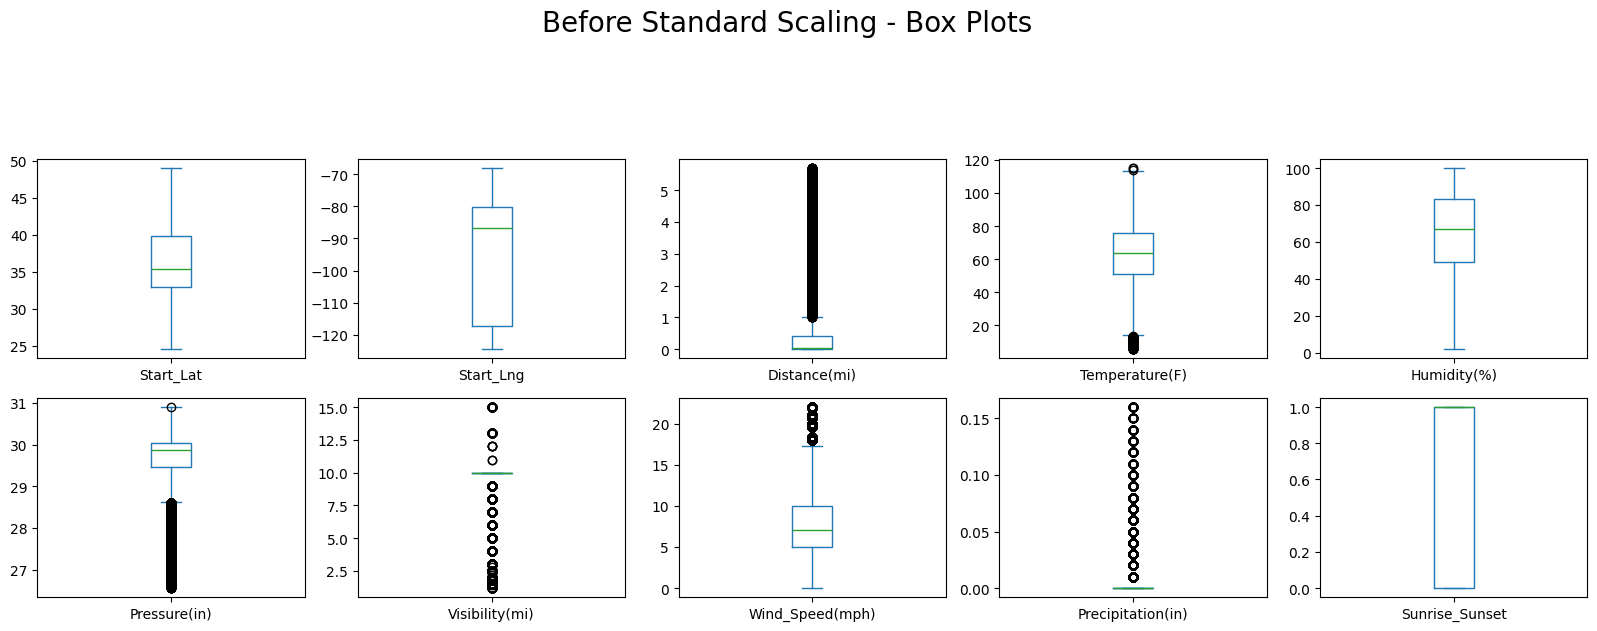

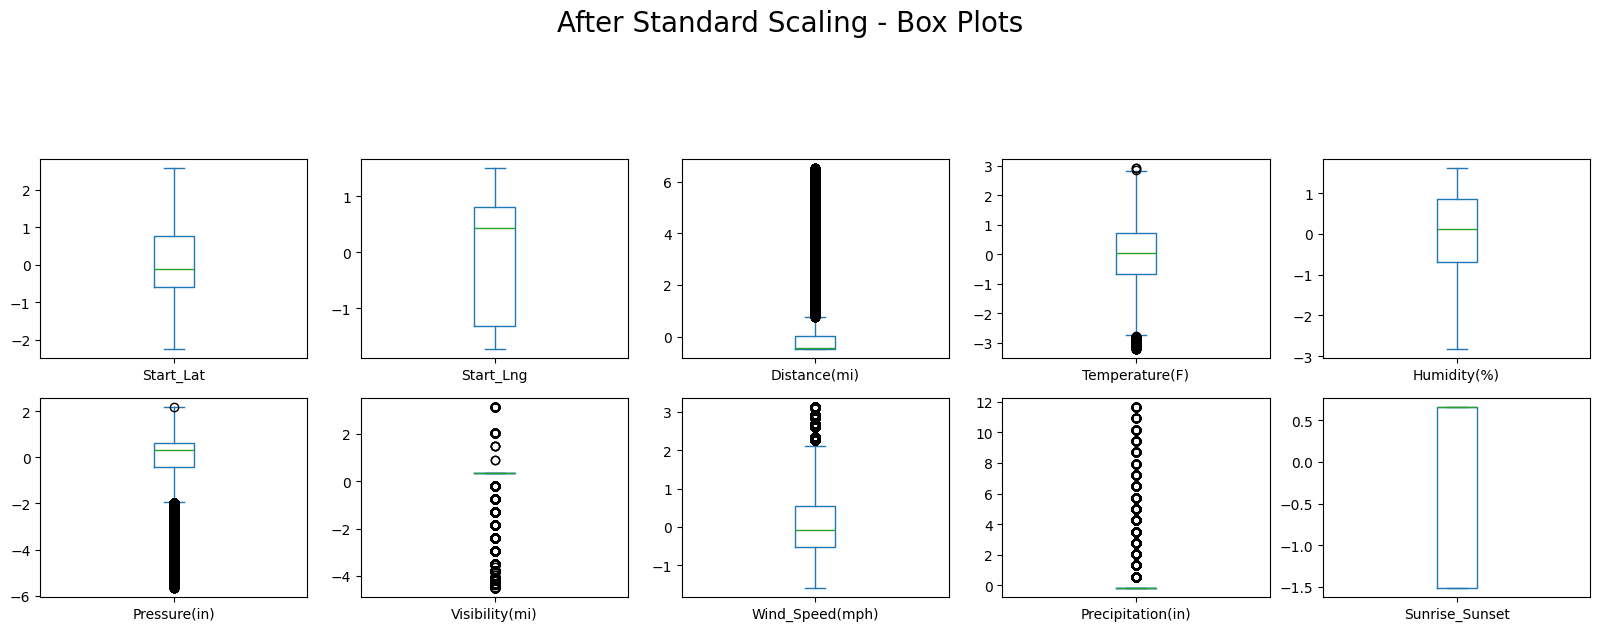

In [23]:
from sklearn.preprocessing import StandardScaler
from scipy import stats

columns_to_scale = [col for col in numerical_columns if col != 'Year']

z_scores = np.abs(stats.zscore(df[columns_to_scale]))
threshold = 3  # Common threshold for Z-score
df = df[(z_scores < threshold).all(axis=1)]

df[columns_to_scale].plot(kind='box', subplots=True, layout=(5, 5), figsize=(20, 15), title='Before Standard Scaling - Box Plots')
plt.suptitle('Before Standard Scaling - Box Plots', fontsize=20)
plt.show()

scaler = StandardScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

df[columns_to_scale].plot(kind='box', subplots=True, layout=(5, 5), figsize=(20, 15), title='After Standard Scaling - Box Plots')
plt.suptitle('After Standard Scaling - Box Plots', fontsize=20)
plt.show()

### Final dataset preparation

We select all the preprocessed features for our model input and separate the target variable. This gives us our final X (features) and y (target) datasets ready for model training.

In [24]:
# Ensure 'Severity' is treated as a categorical variable
df['Severity'] = df['Severity'].astype('category')

# Select final features and target
X = df.drop(columns=['Severity'])
y = df['Severity']

# Logistic Regression

### Training

After preprocessing our data, we'll train a logistic regression model to predict accident severity. We'll use scikit-learn's implementation of logistic regression and employ several techniques to ensure we get the best possible model. Logistic regression was chosen as an initial baseline model due to its simplicity and interpretability, as taught in class.

In [25]:
# Imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline

We start by splitting our data into training and test sets:

In [26]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
# Create model and hyperparameters
model = LogisticRegression(random_state=42, max_iter=100)
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__class_weight': [None, 'balanced']
}
pipeline = Pipeline([
    ('classifier', model)
])

In [28]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/ismail/Projects/us-accidents-severity-prediction/.env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ismail/Projects/us-accidents-severity-prediction/.env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ismail/Projects/us-accidents-severity-prediction/.env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ismail/Projects/us-accidents-severity-prediction/.env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ismail/Projects/us-accidents-severity-prediction/.env/lib/python3.12/site-packages/sklearn/li

### Evaluation

In [29]:
# Make predictions on the training set
y_train_pred = best_model.predict(X_train)

# Make predictions on the test set
y_test_pred = best_model.predict(X_test)

# Calculate and print classification reports
print("Training Set Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

# Calculate and print confusion matrices
print("Training Set Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))

print("\nTest Set Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Calculate and print accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Set Accuracy: {train_accuracy:.4f}")
print(f"Test Set Accuracy: {test_accuracy:.4f}")

# Calculate and print F1 scores
train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print(f"Training Set F1 Score: {train_f1:.4f}")
print(f"Test Set F1 Score: {test_f1:.4f}")

Training Set Classification Report:
              precision    recall  f1-score   support

           1       0.05      0.15      0.07       502
           2       0.83      0.88      0.85     44887
           3       0.36      0.24      0.28      9427
           4       0.12      0.06      0.08      1400

    accuracy                           0.75     56216
   macro avg       0.34      0.33      0.32     56216
weighted avg       0.72      0.75      0.73     56216


Test Set Classification Report:
              precision    recall  f1-score   support

           1       0.05      0.15      0.07       126
           2       0.83      0.88      0.85     11221
           3       0.36      0.23      0.28      2357
           4       0.12      0.05      0.08       350

    accuracy                           0.75     14054
   macro avg       0.34      0.33      0.32     14054
weighted avg       0.72      0.75      0.73     14054

Training Set Confusion Matrix:
[[   73   421     8     0]
 [ 

In [33]:
# Example ground truth and predictions
example_indices = np.random.choice(len(X_test), size=5, replace=False)
example_ground_truth = y_test.iloc[example_indices]
example_predictions = y_test_pred[example_indices]

print("\nExample Ground Truth and Predictions:")
for i in range(len(example_indices)):
    print(f"Index: {example_indices[i]}, Ground Truth: {example_ground_truth.iloc[i]}, Prediction: {example_predictions[i]}")


Example Ground Truth and Predictions:
Index: 3732, Ground Truth: 2, Prediction: 2
Index: 9124, Ground Truth: 2, Prediction: 2
Index: 5733, Ground Truth: 3, Prediction: 2
Index: 8972, Ground Truth: 2, Prediction: 2
Index: 13550, Ground Truth: 2, Prediction: 2


The logistic regression model achieves 74% accuracy on both training and test sets, with similar F1 scores (0.36), indicating no overfitting. However, the model struggles with minority classes (1 and 4), suggesting underfitting for these classes. The model seems to struggle with imbalanced data, performing well on the majority class but poorly on minority classes. This suggests potential overfitting to the majority class. On the fitting graph (model complexiy vs. error), this model likely sits in the high bias region (low complexity and high error), showing potential for improvement with increased complexity.

**Next models to consider:**
1. **Random Forest Classifier**: Can handle non-linear relationships and class imbalance.
2. **Gradient Boosting Classifier (e.g., XGBoost)**: Performs well on imbalanced datasets.
3. **Support Vector Machine (SVM)**: Can capture non-linear relationships with kernel tricks.

These models are chosen to address the limitations of logistic regression in handling non-linear relationships and class imbalance.

**Next Steps:**
- Address **class imbalance** using techniques like SMOTE or class weights.
- Implement non-linear models such as Random Forest or Gradient Boosting to capture complex relationships and handle imbalanced data better.
- Increase max_iter parameter to allow for convergence, as the model consistently hit the maximum iterations.
- Feature engineering and selection to improve model performance.
  
These steps aim to move the model towards the "sweet spot" on the fitting graph, balancing bias and variance while addressing the challenges of imbalanced data and convergence issues.

# Random Forest Classifier

### Preprocessing

To address the class imbalance in the dataset, we need to use a resampling technique that oversamples the minority classes and undersamples the majority classes. One popular method for oversampling is the Synthetic Minority Over-sampling Technique (SMOTE), which generates synthetic samples for the minority classes.

In [34]:
from collections import Counter
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

In [35]:
print("Original class distribution:")
print(Counter(df['Severity']))

X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nResampled class distribution:")
print(Counter(y_resampled))

Original class distribution:
Counter({2: 56108, 3: 11784, 4: 1750, 1: 628})

Resampled class distribution:
Counter({3: 56108, 2: 56108, 1: 56108, 4: 56108})


### Training

In [36]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

In [37]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (179545, 36)
Test set shape: (44887, 36)


In [39]:
# Create model and hyperparameters
model = RandomForestClassifier(random_state=42, max_depth=20)
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_features': ['log2', 'sqrt']
}
pipeline = Pipeline([
    ('classifier', model)
])

In [41]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
# grid_search.fit(X_train_res, y_train_res)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'classifier__max_features': 'log2', 'classifier__n_estimators': 200}


### Evaluation

In [42]:
# Make predictions on the training set
y_train_pred = best_model.predict(X_train)

# Make predictions on the test set
y_test_pred = best_model.predict(X_test)

# Calculate and print classification reports
print("Training Set Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

# Calculate and print confusion matrices
print("Training Set Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))

print("\nTest Set Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Calculate and print accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Set Accuracy: {train_accuracy:.4f}")
print(f"Test Set Accuracy: {test_accuracy:.4f}")

# Calculate and print F1 scores
train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print(f"Training Set F1 Score: {train_f1:.4f}")
print(f"Test Set F1 Score: {test_f1:.4f}")

Training Set Classification Report:
              precision    recall  f1-score   support

           1       0.98      1.00      0.99     44886
           2       1.00      0.95      0.97     44887
           3       0.96      0.98      0.97     44886
           4       0.98      1.00      0.99     44886

    accuracy                           0.98    179545
   macro avg       0.98      0.98      0.98    179545
weighted avg       0.98      0.98      0.98    179545


Test Set Classification Report:
              precision    recall  f1-score   support

           1       0.96      1.00      0.98     11222
           2       0.92      0.81      0.86     11221
           3       0.85      0.85      0.85     11222
           4       0.91      0.98      0.94     11222

    accuracy                           0.91     44887
   macro avg       0.91      0.91      0.91     44887
weighted avg       0.91      0.91      0.91     44887

Training Set Confusion Matrix:
[[44876     0     6     4]
 [ 

In [43]:
# Example ground truth and predictions
example_indices = np.random.choice(len(X_test), size=5, replace=False)
example_ground_truth = y_test.iloc[example_indices]
example_predictions = y_test_pred[example_indices]

print("\nExample Ground Truth and Predictions:")
for i in range(len(example_indices)):
    print(f"Index: {example_indices[i]}, Ground Truth: {example_ground_truth.iloc[i]}, Prediction: {example_predictions[i]}")


Example Ground Truth and Predictions:
Index: 44207, Ground Truth: 2, Prediction: 2
Index: 13644, Ground Truth: 4, Prediction: 4
Index: 36626, Ground Truth: 3, Prediction: 3
Index: 41411, Ground Truth: 1, Prediction: 1
Index: 33670, Ground Truth: 2, Prediction: 2


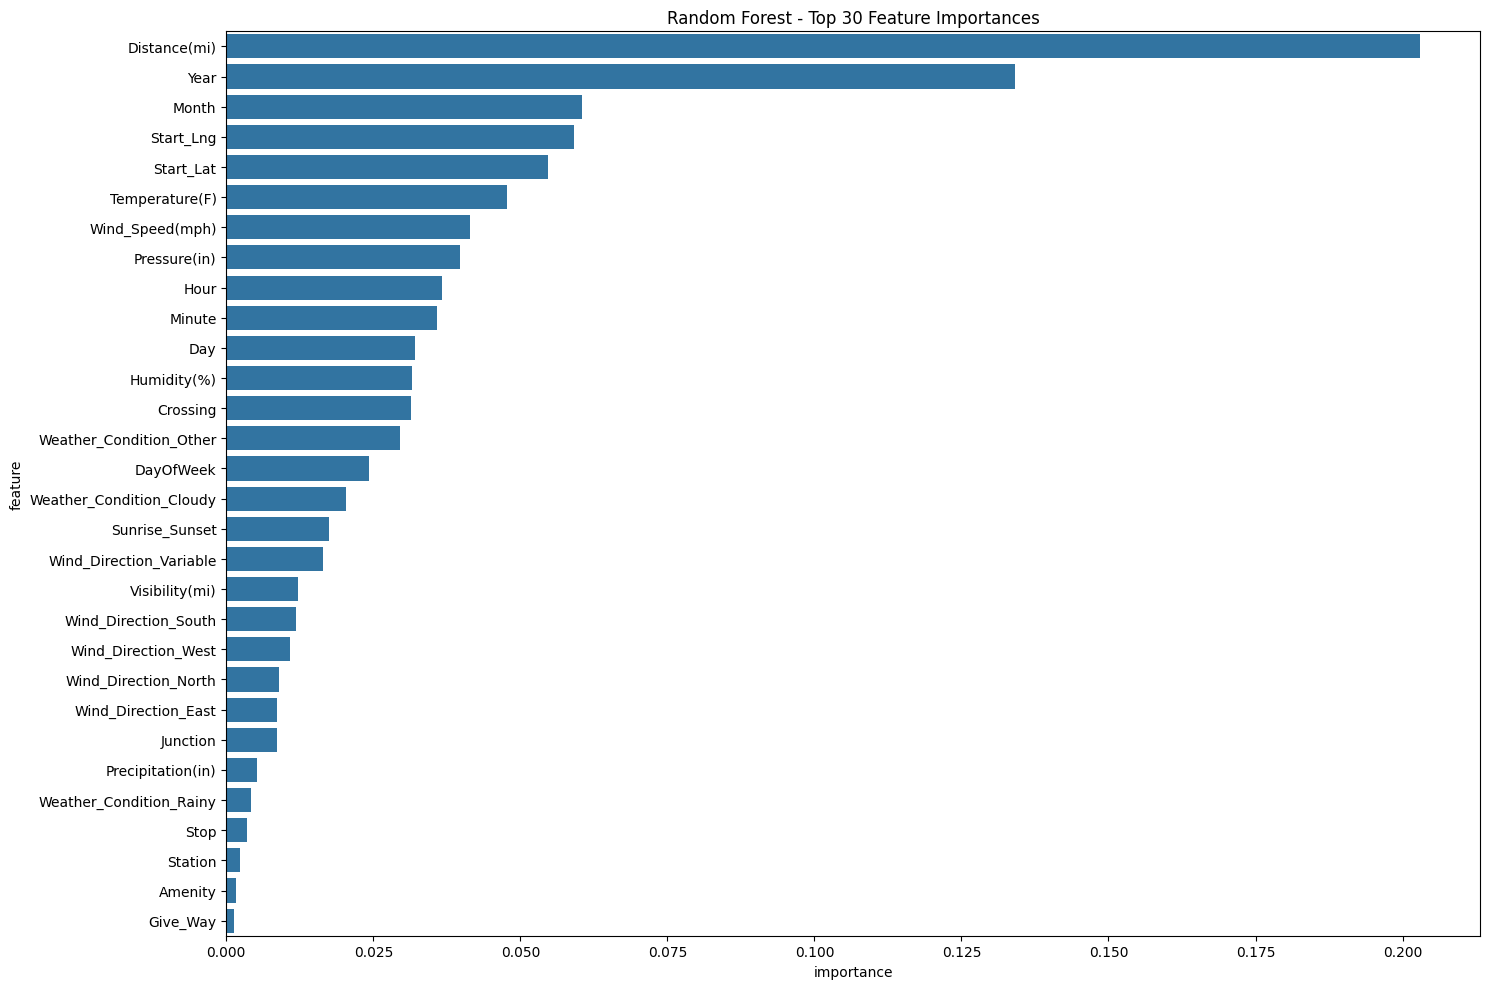

In [44]:
# Get feature importances
importances = pd.DataFrame({'feature': X_train.columns, 
                            'importance': best_model.named_steps['classifier'].feature_importances_})
importances = importances.sort_values('importance', ascending=False).reset_index(drop=True)

# Plot top 30 feature importances
plt.figure(figsize=(15, 10))
sns.barplot(x='importance', y='feature', data=importances.head(30))
plt.title('Random Forest - Top 30 Feature Importances')
plt.tight_layout()
plt.show()

**Model Fit**: The model shows signs of slight overfitting. The training set performance (accuracy 0.9813, F1 score 0.9813) is noticeably better than the test set performance (accuracy 0.9089, F1 score 0.9076). On the fitting graph, this model likely sits near the optimal point, reflecting a good balance between bias and variance, yet there remains potential for further optimization, particularly for improving performance on Classes 2 and 3 in the test set. 

**Conclusion**: The model performs well overall, with high accuracy and F1 scores on both training and test sets. However, there's room for improvement, especially in generalizing to unseen data.

**Possible Improvements**:
- Implement regularization techniques to reduce overfitting.
- Try feature selection to focus on the most important predictors.
- Experiment with ensemble methods or other algorithms.
- Collect more diverse data if possible to improve generalization.
- Fine-tune hyperparameters further, possibly using techniques like Bayesian optimization.